In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# General Information about Data Sets

In [2]:
train2= pd.read_csv('cleaned_train.csv')
weather= pd.read_csv('cleaned_weather.csv')
spray2= pd.read_csv('cleaned_spray.csv')
train= train2.drop(['Year','Month','Day'], axis=1)
spray= spray2.drop(['Year','YearMonth','Day','YearWeek','Month'], axis=1)
train['Date']=pd.to_datetime(train['Date'])
spray['Date']=pd.to_datetime(spray['Date'])
weather['Date']=pd.to_datetime(weather['Date'])
weather['YearWeek']= (weather['Year'].astype(str)+weather['Week'].astype(str)).astype('int64')
weather['YearMonth']=(weather['Year'].astype(str)+weather['Month'].astype(str)).astype('int64')
weather.drop(['Week','Day'], axis=1, inplace=True)

In [3]:
print(train.info(),weather.info(),spray.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9693 entries, 0 to 9692
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          9693 non-null   datetime64[ns]
 1   Species       9693 non-null   object        
 2   Latitude      9693 non-null   float64       
 3   Longitude     9693 non-null   float64       
 4   NumMosquitos  9693 non-null   int64         
 5   WnvPresent    9693 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 454.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tmax         1472 non-null   int64         
 2   Tmin         1472 non-null   int64         
 3   Tavg         1472 non-null   int64         
 4   Depar

In [4]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,YearWeek,YearMonth
0,2007-05-01,83,51,67,14.0,51.0,56.5,0.0,2.5,0.0,29.140,29.820,2.20,26.0,9.40,2007,5,200718,20075
1,2007-05-02,59,42,51,-3.0,42.0,47.0,13.5,0.0,0.0,29.410,30.085,13.15,3.0,13.40,2007,5,200718,20075
2,2007-05-03,66,47,57,2.0,40.0,49.0,8.0,0.0,0.0,29.425,30.120,12.30,6.5,12.55,2007,5,200718,20075
3,2007-05-04,72,50,61,4.0,41.5,50.0,4.0,0.0,0.0,29.335,30.045,10.25,7.5,10.60,2007,5,200718,20075
4,2007-05-05,66,53,60,5.0,38.5,49.5,5.0,0.0,0.0,29.430,30.095,11.45,7.0,11.75,2007,5,200718,20075


In [5]:
weather.isna().any().sum()

0

In [6]:
train.head()

,Date,Species,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0


In [7]:
train.isna().any().sum()

0

# Weather & Train Data Sets - EDA and Feature Engineering

According to the researches, if the weather gets too hot and too dry, mosquitoes will not be as active and feeding as they usually are. But once the humidity increases they’re more hungry and biting more.Therefore humidity plays a key role in WVN Presence. We will add the relative humidity as a feature.

In [8]:
# calculation of RELATIVE HUMIDITY
def rel_humidity(df,T, Td,Tw):
    
# Convert the air temperature and dew-point temperature to Celsius.(C=5*(F-32)/9)
    Tc= (5.0*(df[T]-32))/9.0
    Tdc= (5.0*(df[Td]-32))/9.0

#Calculate the saturated vapor pressure with a formula.  
    es=6.11*10.0**(7.5*Tc/(237.7+Tc))

#Find the actual vapor pressure with the same formula.
    e=6.11*10.0**(7.5*Tdc/(237.7+Tdc))
    
#Calculate the relative humidity.    
    df['RelHumidity']= round((e/es)*100)
    return df

In [9]:
rel_humidity(weather,'Tavg','DewPoint', 'WetBulb')

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,YearWeek,YearMonth,RelHumidity
0,2007-05-01,83,51,67,14.0,51.0,56.5,0.0,2.5,0.000,29.140,29.820,2.20,26.0,9.40,2007,5,200718,20075,56.0
1,2007-05-02,59,42,51,-3.0,42.0,47.0,13.5,0.0,0.000,29.410,30.085,13.15,3.0,13.40,2007,5,200718,20075,71.0
2,2007-05-03,66,47,57,2.0,40.0,49.0,8.0,0.0,0.000,29.425,30.120,12.30,6.5,12.55,2007,5,200718,20075,53.0
3,2007-05-04,72,50,61,4.0,41.5,50.0,4.0,0.0,0.000,29.335,30.045,10.25,7.5,10.60,2007,5,200718,20075,49.0
4,2007-05-05,66,53,60,5.0,38.5,49.5,5.0,0.0,0.000,29.430,30.095,11.45,7.0,11.75,2007,5,200718,20075,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78,52,65,16.0,51.5,58.5,0.5,1.0,0.010,28.960,29.665,12.35,19.0,13.25,2014,10,201444,201410,62.0
1468,2014-10-28,67,46,57,10.0,39.0,47.5,8.0,0.0,0.025,29.190,29.850,14.40,26.0,15.10,2014,10,201444,201410,51.0
1469,2014-10-29,49,38,44,-4.0,33.0,41.0,21.0,0.0,0.000,29.390,30.065,9.00,29.0,9.45,2014,10,201444,201410,65.0
1470,2014-10-30,52,34,43,-4.0,34.5,41.0,21.5,0.0,0.000,29.375,30.095,5.50,23.5,6.00,2014,10,201444,201410,72.0


I will calculate time lags by giving higher weights to the most recent observed values.

# EWMA

In [10]:
def ema(df,col, span):
    df[f'{col}_{span}']= round(df[col].ewm(span=span, adjust=True).mean(),2)
    return df.dropna()
ema_list= ['Tmax', 'DewPoint','WetBulb','PrecipTotal', 'StnPressure','SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed','RelHumidity']
span= list(np.arange(3,22,2))
for i in ema_list:
    for s in span:
        ema(weather,i,s)

In [11]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,...,RelHumidity_3,RelHumidity_5,RelHumidity_7,RelHumidity_9,RelHumidity_11,RelHumidity_13,RelHumidity_15,RelHumidity_17,RelHumidity_19,RelHumidity_21
0,2007-05-01,83,51,67,14.0,51.0,56.5,0.0,2.5,0.0,...,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00,56.00
1,2007-05-02,59,42,51,-3.0,42.0,47.0,13.5,0.0,0.0,...,66.00,65.00,64.57,64.33,64.18,64.08,64.00,63.94,63.89,63.86
2,2007-05-03,66,47,57,2.0,40.0,49.0,8.0,0.0,0.0,...,58.57,59.32,59.57,59.69,59.76,59.80,59.83,59.86,59.87,59.89
3,2007-05-04,72,50,61,4.0,41.5,50.0,4.0,0.0,0.0,...,53.47,55.03,55.70,56.07,56.30,56.45,56.56,56.65,56.71,56.77
4,2007-05-05,66,53,60,5.0,38.5,49.5,5.0,0.0,0.0,...,49.10,51.18,52.19,52.78,53.15,53.41,53.59,53.74,53.85,53.94


In [12]:
weather.isna().any().sum()

0

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Columns: 120 entries, Date to RelHumidity_21
dtypes: datetime64[ns](1), float64(112), int64(7)
memory usage: 1.3 MB


In [14]:
w_train= train.merge(weather, on= ['Date'])
w_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Columns: 125 entries, Date to RelHumidity_21
dtypes: datetime64[ns](1), float64(114), int64(9), object(1)
memory usage: 9.3+ MB


**The below chart indicates CULEX RESTUANS species were most affected by temperature increases.**

In [15]:
w_train=pd.get_dummies(w_train,drop_first=True)
#w_train=pd.get_dummies(w_train)
w_train.head()

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,...,RelHumidity_15,RelHumidity_17,RelHumidity_19,RelHumidity_21,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,2007-05-29,41.954690,-87.800991,1,0,88,62,75,10.0,58.5,...,53.98,53.68,53.45,53.26,0,1,0,0,0,0
1,2007-05-29,41.954690,-87.800991,1,0,88,62,75,10.0,58.5,...,53.98,53.68,53.45,53.26,0,0,1,0,0,0
2,2007-05-29,41.994991,-87.769279,1,0,88,62,75,10.0,58.5,...,53.98,53.68,53.45,53.26,0,0,1,0,0,0
3,2007-05-29,41.974089,-87.824812,1,0,88,62,75,10.0,58.5,...,53.98,53.68,53.45,53.26,0,1,0,0,0,0
4,2007-05-29,41.974089,-87.824812,4,0,88,62,75,10.0,58.5,...,53.98,53.68,53.45,53.26,0,0,1,0,0,0


In [16]:
w_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Columns: 130 entries, Date to Species_CULEX TERRITANS
dtypes: datetime64[ns](1), float64(114), int64(9), uint8(6)
memory usage: 9.3 MB


In [17]:
w_train.isna().any().sum()

0

In [18]:
print('\n','The Percantage of Virus per Each Species  ','\n')
print('CULEX PIPIENS: ', round(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS'].sum()/len(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS'])*100,2))
print('CULEX RESTUANS: ', round(w_train[w_train.WnvPresent==1]['Species_CULEX RESTUANS'].sum()/len(w_train[w_train.WnvPresent==1]['Species_CULEX RESTUANS'])*100,2))
print('CULEX PIPIENS/RESTUANS: ', round(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS/RESTUANS'].sum()/len(w_train[w_train.WnvPresent==1]['Species_CULEX PIPIENS/RESTUANS'])*100),2)


 The Percantage of Virus per Each Species   

CULEX PIPIENS:  41.35
CULEX RESTUANS:  9.74
CULEX PIPIENS/RESTUANS:  49.0 2


**The below Correlation report indicates Relative Humidity is highly correlated with WN Virus, consequently Dew Temperature and Wet Bulb. Also their 7 and 14 days Exponential Mean Averages have higher correlation than the actual observation values. This must be because of the incubation period.**

figure = plt.figure(figsize=(10,40))
sns.heatmap(w_train.corr()[['WnvPresent']].sort_values('WnvPresent',ascending=False),annot=True, cmap='YlGnBu')

**We will check if there is multicollinearity among the features and fix them.**

In [19]:
X = w_train.drop('WnvPresent', axis=1)
y = w_train['WnvPresent']
X_train,X_test, y_train,y_test = train_test_split(X, y,test_size=0.3)
print(X_train.shape, y_train.shape)
print(len(X_train.columns[X_train.isna().any()]))

(6785, 129) (6785,)
0


Weight of Evidence (WOE) helps to transform a continuous independent variable into a set of groups or bins based on similarity of dependent variable distribution i.e. number of events and non-events.
Informtion of Evidence (IV) helps to rank variables on the basis of their importance. It measures predictive power of independent variables

Information value is not an optimal feature (variable) selection method when you are building a classification model other than binary logistic regression (for eg. random forest or SVM) as conditional log odds (which we predict in a logistic regression model) is highly related to the calculation of weight of evidence. In other words, it's designed mainly for binary logistic regression model. Also think this way - Random forest can detect non-linear relationship very well so selecting variables via Information Value and using them in random forest model might not produce the most accurate and robust predictive model.

In [20]:
pd.options.mode.use_inf_as_na = True
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [21]:
final_iv, IV = data_vars(X_train, y_train)

C:\Users\laptop\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
final_iv.head()

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Date,2007-05-29 00:00:00,2007-05-29 00:00:00,16,0,0.0,16,1.0,0.0,0.002489,0.0,0.919056
1,Date,2007-06-05 00:00:00,2007-06-05 00:00:00,37,0,0.0,37,1.0,0.0,0.005756,0.0,0.919056
2,Date,2007-06-26 00:00:00,2007-06-26 00:00:00,46,0,0.0,46,1.0,0.0,0.007156,0.0,0.919056
3,Date,2007-06-29 00:00:00,2007-06-29 00:00:00,32,0,0.0,32,1.0,0.0,0.004978,0.0,0.919056
4,Date,2007-07-02 00:00:00,2007-07-02 00:00:00,50,0,0.0,50,1.0,0.0,0.007778,0.0,0.919056


In [23]:
final_iv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   VAR_NAME        463 non-null    object 
 1   MIN_VALUE       463 non-null    object 
 2   MAX_VALUE       463 non-null    object 
 3   COUNT           463 non-null    int64  
 4   EVENT           463 non-null    int64  
 5   EVENT_RATE      463 non-null    float64
 6   NONEVENT        463 non-null    int64  
 7   NON_EVENT_RATE  463 non-null    float64
 8   DIST_EVENT      463 non-null    float64
 9   DIST_NON_EVENT  463 non-null    float64
 10  WOE             463 non-null    float64
 11  IV              463 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 43.5+ KB


In [24]:
final_iv.isna().any().sum()

0

In [25]:
IV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VAR_NAME  129 non-null    object 
 1   IV        129 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


In [26]:
IV.isna().any().sum()

0

In [27]:
features = list(IV[(IV['IV'] >= 0.1) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
X2.head()

,AvgSpeed_15,AvgSpeed_17,AvgSpeed_19,AvgSpeed_21,Depart,DewPoint,DewPoint_11,DewPoint_13,DewPoint_15,DewPoint_17,...,WetBulb_11,WetBulb_13,WetBulb_15,WetBulb_17,WetBulb_19,WetBulb_21,WetBulb_3,WetBulb_5,WetBulb_7,WetBulb_9
1215,6.69,6.82,6.94,7.04,8.0,66.0,61.18,60.92,60.70,60.50,...,67.26,66.94,66.68,66.47,66.28,66.12,69.78,68.79,68.14,67.65
2062,6.89,6.88,6.88,6.88,9.0,70.5,65.32,65.12,64.95,64.79,...,68.40,68.34,68.30,68.26,68.22,68.16,71.03,69.51,68.81,68.52
5852,7.63,7.70,7.77,7.85,7.0,70.5,61.17,60.81,60.54,60.30,...,67.66,67.28,66.95,66.65,66.37,66.10,71.32,69.67,68.74,68.13
7393,8.97,9.01,9.05,9.09,-6.0,44.5,49.65,49.90,50.00,49.99,...,55.14,55.35,55.45,55.48,55.44,55.37,52.67,53.45,54.21,54.77
1114,6.71,6.86,6.98,7.09,8.0,62.5,60.21,60.07,59.94,59.82,...,66.41,66.18,66.00,65.84,65.70,65.58,68.07,67.44,67.02,66.68


In [28]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6785 entries, 1215 to 8133
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AvgSpeed_15             6785 non-null   float64
 1   AvgSpeed_17             6785 non-null   float64
 2   AvgSpeed_19             6785 non-null   float64
 3   AvgSpeed_21             6785 non-null   float64
 4   Depart                  6785 non-null   float64
 5   DewPoint                6785 non-null   float64
 6   DewPoint_11             6785 non-null   float64
 7   DewPoint_13             6785 non-null   float64
 8   DewPoint_15             6785 non-null   float64
 9   DewPoint_17             6785 non-null   float64
 10  DewPoint_19             6785 non-null   float64
 11  DewPoint_21             6785 non-null   float64
 12  DewPoint_3              6785 non-null   float64
 13  DewPoint_5              6785 non-null   float64
 14  DewPoint_7              6785 non-null

In [30]:
X_train = X2._get_numeric_data()
X_test= X_test[X_train.columns]

In [31]:
X_train.isna().any().sum()

0

In [32]:
y_train.value_counts()   # IMBALANCED DATA !!!

0    6428
1     357
Name: WnvPresent, dtype: int64

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,f1_score

rf= RandomForestClassifier()

rf_params = { 'n_estimators': [500,600,800,1000,1500,2000,3000,4000], 
             'max_features': ['auto', 'sqrt', 'log2'], 
             'max_depth' : [4,5,6,7,8,9], 
             'criterion' :['gini', 'entropy'],
            'min_samples_split' : [2, 3, 4] }

rf_random= RandomizedSearchCV(rf, rf_params, cv=5, n_jobs=-1)

rf_random= rf_random.fit(X_train, y_train)

y_pred = rf_random.predict(X_test)

roc= roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('F1-score=%.3f' % (f1))
print("Best Score: " + str(round(rf_random.best_score_,4)))
print("Best Parameters: " , rf_random.best_params_)
print("ROC AUC:", round(roc,4))
print("Confusion Matrix: " ,'\n', cm)
print("Classsification Report: ",'\n', classification_report(y_test, y_pred))

F1-score=0.925
Best Score: 0.9474
Best Parameters:  {'n_estimators': 800, 'min_samples_split': 3, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}
ROC AUC: 0.5
Confusion Matrix:  
 [[2762    0]
 [ 146    0]]
Classsification Report:  
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2762
           1       0.00      0.00      0.00       146

    accuracy                           0.95      2908
   macro avg       0.47      0.50      0.49      2908
weighted avg       0.90      0.95      0.93      2908



C:\Users\laptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


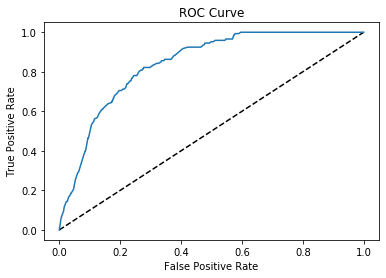

In [34]:
y_pred_proba=rf_random.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr, label= 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

53


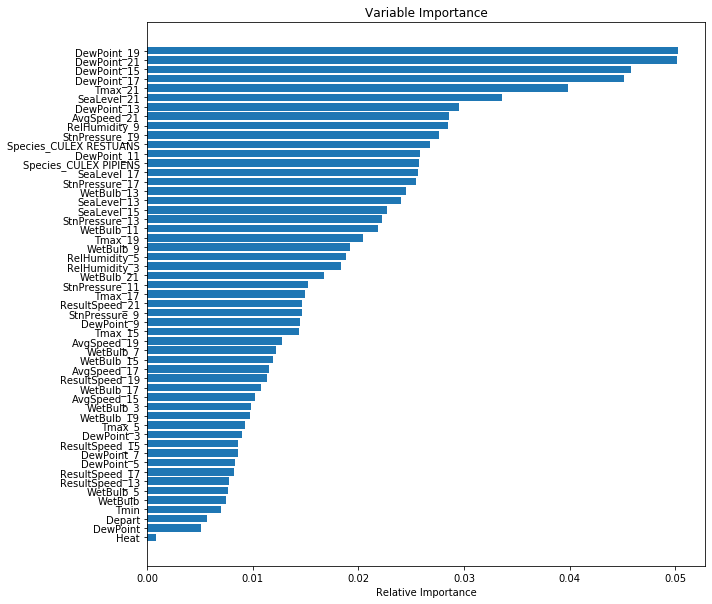

In [35]:
rf_random= rf_random.best_estimator_
feature_importance = rf_random.feature_importances_
#make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
#sorted_idx = np.argsort(feature_importance)[:30]
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [36]:
df= pd.DataFrame({'feature':X_train.columns,'importance':feature_importance}).sort_values('importance',ascending=False)
df.head(15)

,feature,importance
10,DewPoint_19,0.050288
11,DewPoint_21,0.050187
8,DewPoint_15,0.045798
9,DewPoint_17,0.045162
39,Tmax_21,0.039826
28,SeaLevel_21,0.033555
7,DewPoint_13,0.029543
3,AvgSpeed_21,0.028583
19,RelHumidity_9,0.028501
34,StnPressure_19,0.027637


In [37]:
df_new=df.sort_values(by=['importance'], ascending=False)[:15]
df_new

,feature,importance
10,DewPoint_19,0.050288
11,DewPoint_21,0.050187
8,DewPoint_15,0.045798
9,DewPoint_17,0.045162
39,Tmax_21,0.039826
28,SeaLevel_21,0.033555
7,DewPoint_13,0.029543
3,AvgSpeed_21,0.028583
19,RelHumidity_9,0.028501
34,StnPressure_19,0.027637


In [46]:
df_new.feature.unique()

array(['DewPoint_19', 'DewPoint_21', 'DewPoint_15', 'DewPoint_17',
       'Tmax_21', 'SeaLevel_21', 'DewPoint_13', 'AvgSpeed_21',
       'RelHumidity_9', 'StnPressure_19', 'Species_CULEX RESTUANS',
       'DewPoint_11', 'Species_CULEX PIPIENS', 'SeaLevel_17',
       'StnPressure_17'], dtype=object)

In [39]:
filtered_columns=['DewPoint_19', 'DewPoint_21', 'DewPoint_15', 'DewPoint_17',
       'Tmax_21', 'SeaLevel_21', 'DewPoint_13', 'AvgSpeed_21',
       'RelHumidity_9', 'StnPressure_19', 'Species_CULEX RESTUANS',
       'DewPoint_11', 'Species_CULEX PIPIENS', 'SeaLevel_17',
       'StnPressure_17']

In [40]:
X_filtered= X_train[filtered_columns]
X_filtered.head()

,DewPoint_19,DewPoint_21,DewPoint_15,DewPoint_17,Tmax_21,SeaLevel_21,DewPoint_13,AvgSpeed_21,RelHumidity_9,StnPressure_19,Species_CULEX RESTUANS,DewPoint_11,Species_CULEX PIPIENS,SeaLevel_17,StnPressure_17
1215,60.33,60.18,60.70,60.50,84.51,29.98,60.92,7.04,58.74,29.30,0,61.18,1,29.98,29.31
2062,64.63,64.47,64.95,64.79,81.84,29.96,65.12,6.88,76.08,29.28,0,65.32,0,29.96,29.28
5852,60.09,59.88,60.54,60.30,84.81,29.90,60.81,7.85,58.00,29.22,1,61.17,0,29.90,29.23
7393,49.92,49.80,50.00,49.99,70.65,29.95,49.90,9.09,64.23,29.26,1,49.65,0,29.95,29.26
1114,59.70,59.59,59.94,59.82,83.86,29.98,60.07,7.09,58.42,29.31,0,60.21,0,29.98,29.31


In [41]:
def iterate_vif(df, vif_threshold=50, max_vif=55):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if round((vif['VIFactor'].max()),1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], round((vif['VIFactor'].max()),1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = round((vif['VIFactor'].max()),1)
    else:
        print('Complete')
        return df, round((vif.sort_values('VIFactor')),1)



In [42]:
final_df, final_vif = iterate_vif(X_filtered)

Iteration # 1
Removing DewPoint_19 with VIF of 322626824.700000
Iteration # 2
Removing DewPoint_15 with VIF of 227600397.800000
Iteration # 3
Removing StnPressure_19 with VIF of 77120041.000000
Iteration # 4
Removing SeaLevel_17 with VIF of 57427246.400000
Iteration # 5
Removing DewPoint_13 with VIF of 25078657.300000
Iteration # 6
Removing SeaLevel_21 with VIF of 15261046.900000
Iteration # 7
Removing DewPoint_17 with VIF of 385501.300000
Iteration # 8
Removing Tmax_21 with VIF of 11562.400000
Iteration # 9
Removing DewPoint_21 with VIF of 2500.200000
Iteration # 10
Removing StnPressure_17 with VIF of 530.300000
Iteration # 11
Removing RelHumidity_9 with VIF of 135.400000
Iteration # 12
Complete


In [43]:
final_vif

,VIFactor,features
3,1.5,Species_CULEX PIPIENS
1,1.6,Species_CULEX RESTUANS
0,38.1,AvgSpeed_21
2,38.1,DewPoint_11


In [44]:
final_df.head()

,AvgSpeed_21,Species_CULEX RESTUANS,DewPoint_11,Species_CULEX PIPIENS
1215,7.04,0,61.18,1
2062,6.88,0,65.32,0
5852,7.85,1,61.17,0
7393,9.09,1,49.65,0
1114,7.09,0,60.21,0
